Jose Valenti's 2-D testing notebook with SEA swimming kernel added

# Load packages and functions

In [ ]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet, Variable, JITParticle, ErrorCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from datetime import datetime
import os

from IPython.display import Image
rc('animation', html='html5')

In [ ]:
# Define SalishSeaCast results filepath
def make_prefix(date, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """
    path = '/results2/SalishSea/nowcast-green.202111/'
    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

# Set 2D model parameters

In [60]:
# Pick hour, day and location for simulation
hour = 0 # Choose start hour
path_NEMO = make_prefix(datetime(2018, 8, 1)) # Choose start year, month, day
lati = 49.224563 # Choose coords
loni = -123.605357
jjii = xr.open_dataset('/home/sallen/MEOPAR/grid/grid_from_lat_lon_mask999.nc') # This is a file that gives the closest SalishSeaCast grid point (i and j) for a given lat and lon 
j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0] # j is the index along the SalishSeaCast grid (think y axis of model domain, or similar to latitude), while i is the index across the grid
i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]

# Specify some simulation parameters
T = 6 * 86400 #s (run time) (86400 s = 24 hours/1 day) - initially 5e3 * 100 (this is about 5.7 days)
dt = 5 #s (timestep)
N = 10e3 #number of particles
outputdt = 3600 #s (3600 = 1 hr) (how often do you want output?) initially 500
outputpath = '/ocean/mattmiller/MOAD/results/parcels/test/Outputmix_sink_and_swim_6_days.zarr' # this makes sure the results are saved in my /results folder located beside /analysis-matt

In [61]:
# Load data from NEMO
Wdat = xr.open_dataset(path_NEMO+'_grid_W.nc', decode_times=False) # Opens the W grid data from SSC (w is the index along the depth axis of SSC)
mbathy = xr.open_dataset('/ocean/jvalenti/MOAD/grid/mesh_mask202108.nc').mbathy[0,j,i].item() # The grid point is 37
depth = np.array(Wdat.depthw[:mbathy+1]).astype('float32') 
Kz_col = np.array(Wdat.vert_eddy_diff[hour,:mbathy+1,j,i]).astype('float32') # Assigns the vertical_eddy_diffusivity values to "Kz_col"
#Kz_col[0]=Kz_col[1] # ? Can I delete this line?

Dt should be << 364.6658286739023


/tmp/ipykernel_282984/3686291716.py:6: RuntimeWarning: divide by zero encountered in divide
  dtmax = np.min(1/abs(Kzp2))


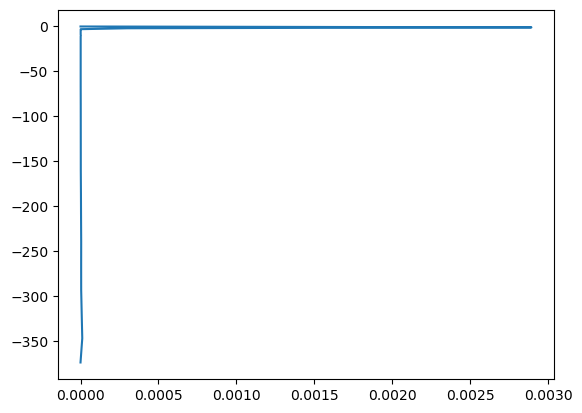

In [ ]:
# plots depth profile of vertical eddy diffusivity
depth2 = np.arange(depth[0],depth[-1],1)
Kz2 = np.interp(depth2, depth, Kz_col)
plt.plot(Kz_col,-depth)
Kzp = np.gradient(Kz2, depth2[1]-depth2[0])
Kzp2 = np.gradient(Kzp, depth2[1]-depth2[0])
dtmax = np.min(1/abs(Kzp2))
print(f'Dt should be << {dtmax}')

# Define parcels kernels and variables

In [62]:
# Here you can define as many particle variables as you want specifying the initial values. In this case, I use the variable to set a constant.
class MPParticle(JITParticle):
    Kh = Variable('Kh', initial =  0.0) # If you want horizontal mixing activated change value here - for this 2D simulation I don't want them to move horizontally b/c that would carry them out of the model bounds
    bath = Variable('bath', initial= depth[-1])

In [63]:
# Delete particle kernel
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure"""
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [65]:
# Mixing Kernel ? I'm not sure what most of these lines do. Could you annotate/explain?
def tu_mix(particle,fieldset,time): 
    bath = particle.bath #109.73707
    if particle.depth+1 > bath: #Forward euler
        Kzdz = (fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-1,particle.lat, particle.lon]) #forward difference 
    else:
        Kzdz = (fieldset.Kz[time,particle.depth+1,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #backward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad > 0 and particle.depth+0.5*dgrad < bath:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        kk = fieldset.Kz[time, bath,particle.lat, particle.lon] #Vertical diffusivity SSC 
    Kx = particle.Kh
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.depth > bath: #randomly in boundary mixed layer
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [ ]:
# Swimming Kernel - original
def tu_swim(particle, fieldset, time):
    mbath = particle.bath
    sink = 20e-3 # m/s 
    swim = 32.5e-3 # m/s 
    dt = 200 # how often they change direction
    kappa = swim**2 * dt # Double asterisk means exponential
    eff_swim = sqrt(kappa / particle.dt) # what does eff_swim represent?
    upward = 1.05   # tendency to swim more upward than sink
    zswim = (- particle.dt * (upward-1) * sink + particle.dt * (eff_swim - upward*sink) * math.cos(ParcelsRandom.uniform(0, 2* math.pi))) # what does zswim represent?
    if particle.depth + zswim < 0:
        particle.depth = 0
    elif particle.depth + zswim > mbath:
        particle.depth = mbath
    else:
        particle.depth += zswim

In [ ]:
# Swimming Kernel - 40 mm/s sink, 30 mm/s swim
def tu_swim(particle, fieldset, time):
    mbath = particle.bath
    sink = 40e-3 # m/s (initial = 20e-3) the sinking speed should exceed the swimming speed. the random direction change switches them between swimming and sinking, and the 1.05 means they are swimming 5% more often than sinking
    swim = 30e-3 # m/s (initial = 32.5e-3)
    dt = 200 # how often they change direction
    kappa = swim**2 * dt # Double asterisk means exponential
    eff_swim = sqrt(kappa / particle.dt) # what does eff_swim represent?
    upward = 1.05   # tendency to swim more upward than sink
    zswim = (- particle.dt * (upward-1) * sink + particle.dt * (eff_swim - upward*sink) * math.cos(ParcelsRandom.uniform(0, 2* math.pi))) # what does zswim represent?
    if particle.depth + zswim < 0:
        particle.depth = 0
    elif particle.depth + zswim > mbath:
        particle.depth = mbath
    else:
        particle.depth += zswim

# Define parcels fieldset

In [67]:
# Define domain, velocity fields and Kz 
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)

# Build fieldsets for OceanParcels
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth) # in parcels, 'U' represents the zonal flow velocity (zonal = east-to-west/west-to-east)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth) # in parcels, 'V' represents the meridional flow velocity (meridional = north-to-south/south-to-north)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col   
Kz = Field('Kz', Kz_data, grid=U.grid)
fieldset = FieldSet(U,V)
fieldset.add_field(Kz)

In [68]:
# Start with random distribution
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(int(N),))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(int(N),))
lat_g = np.zeros(int(N),)

In [69]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(
        fieldset = fieldset, 
        pclass = MPParticle, 
        lon = lon_g, 
        lat = lat_g, 
        depth = depth_g)
    output_file = pset.ParticleFile(name=outputpath, outputdt=outputdt)
    KE = tu_swim + pset.Kernel(tu_mix) #if you want to add more kernels use:  KE = tu_mix + NAME_KERNEL1 + ...
    pset.execute(KE , runtime=T, dt=dt, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

60 day simulation with 5 s timestep and output every hour with 10000 particles took 73 minutes on char

6 day simulation with 5 s timestep and output every hour with 10000 particles took 4 minutes minutes on char

Look into parcels documentation about chunks and how to set to optimize file writing

In [70]:
# runs the simulation? using only the parameters specified here?
run_turb_test(lon_g, depth_g)

INFO: Compiled ArrayMPParticletu_swimtu_mix ==> /tmp/parcels-2928/libdf9b5e813422fc227be07ae8aed76512_0.so
INFO: Output files are stored in /ocean/mattmiller/MOAD/results/parcels/test/Outputmix_sink_and_swim_6_days.zarr.
100%|██████████| 518400.0/518400.0 [04:05<00:00, 2109.30it/s]


Load data

In [71]:
dat = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Outputmix_sink_and_swim_6_days.zarr')
#dat = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Outputmix_sink_and_swim_60_days.zarr')
#dat = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Outputmix_sink_and_swim.zarr')
#dat = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Outputmix_no_sink.zarr')
#dat = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Outputmix_passive_particles.zarr')

/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [9]:
# View data
print(dat)

<xarray.Dataset>
Dimensions:     (trajectory: 10000, obs: 1001)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999 1000
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
Data variables:
    Kh          (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bath        (trajectory, obs) float32 374.1 374.1 374.1 ... 374.1 374.1
    lat         (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon         (trajectory, obs) float32 306.9 306.9 306.9 ... 495.9 495.9
    time        (trajectory, obs) timedelta64[ns] 00:00:00 ... 5 days 18:53:20
    z           (trajectory, obs) float32 285.4 282.5 287.8 ... 52.92 62.54 70.4
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           flat
    parcels_version:        2.4.0


In [27]:
print(dat.time[0, -1].values.astype('timedelta64[ns]') / np.timedelta64(1, 'D'))

5.787037037037037


Plots

284

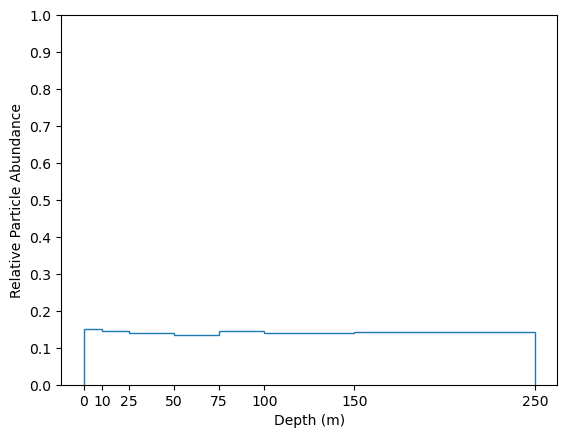

In [47]:
# Initial timestep
binwidths = [10, 15, 25, 25, 25, 50, 100]
counts, bins = np.histogram(dat.z[:, 0], bins = [0, 10, 25, 50, 75, 100, 150, 250])
plt.stairs((counts/binwidths)/sum(counts/binwidths), bins)
plt.xticks([0, 10, 25, 50, 75, 100, 150, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Depth (m)')
plt.ylabel('Relative Particle Abundance')
counts[0]

2221

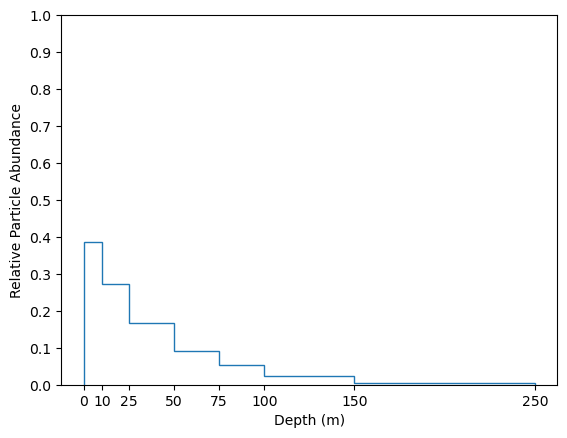

In [48]:
# Final timestep
binwidths = [10, 15, 25, 25, 25, 50, 100]
counts, bins = np.histogram(dat.z[:, -1], bins = [0, 10, 25, 50, 75, 100, 150, 250])
plt.stairs((counts/binwidths)/sum(counts/binwidths), bins)
plt.xticks([0, 10, 25, 50, 75, 100, 150, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Depth (m)')
plt.ylabel('Relative Particle Abundance')
counts[0]

Text(0.5, 0.98, 'Sink and Swim')

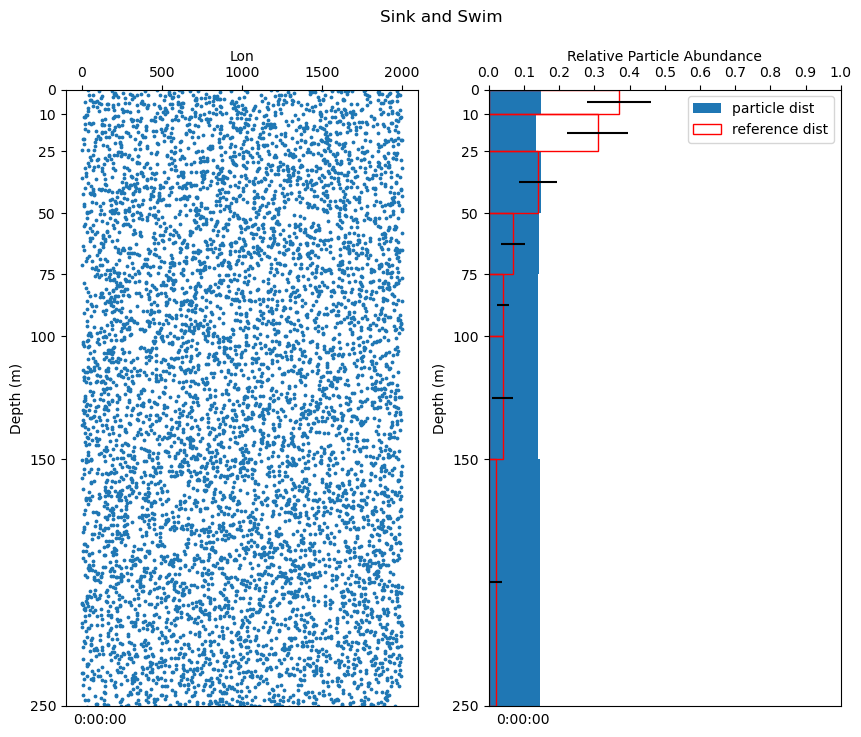

In [72]:
# sink_and_swim - initial timestep
counts, bins = np.histogram(dat.z[:, 0], bins=[0, 10, 25, 50, 75, 100, 150, 250]) # Calculate the counts and bins for the histogram
bin_centers = [0,  10,  25,  50,  75, 100, 150] # Calculate the bin centers (for placing bins on the y-axis
binwidths = np.diff(bins) #[10, 15, 25, 25, 25, 50, 100] # Define the binwidths
relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
vertical_dist = [0.37, 0.31, 0.14, 0.07, 0.04, 0.04, 0.02] # bin means from all day and night LimS0 standard interval tows
xerr = [0.090, 0.087, 0.053, 0.034, 0.017, 0.030, 0.017] # 95% confidence intervals for the means from all day and night LimS0 standard interval tows (n = 38)
tstamp = dat.time[0, 0].values.astype('timedelta64[D]').astype(datetime)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.scatter(dat.lon[:,0],dat.z[:,0],s=3,c ='tab:blue')
ax1.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax1.set_ylim(0, 250)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Depth (m)')
ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes)
ax2.barh(bin_centers, relative_abundance, label = 'particle dist', height=binwidths, align='edge', color='tab:blue') # Create the histogram with bins on the y-axis and counts on the x-axis
ax2.barh(bin_centers, vertical_dist, label = 'reference dist', height=binwidths, align='edge', color='none', edgecolor ='r', xerr = xerr) # Plot reference vertical distribution
ax2.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax2.set_ylim(0, 250)
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
ax2.set_ylabel('Depth (m)')
ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes)
ax2.legend()
plt.suptitle('Sink and Swim')

Text(0.5, 0.98, 'Sink and Swim')

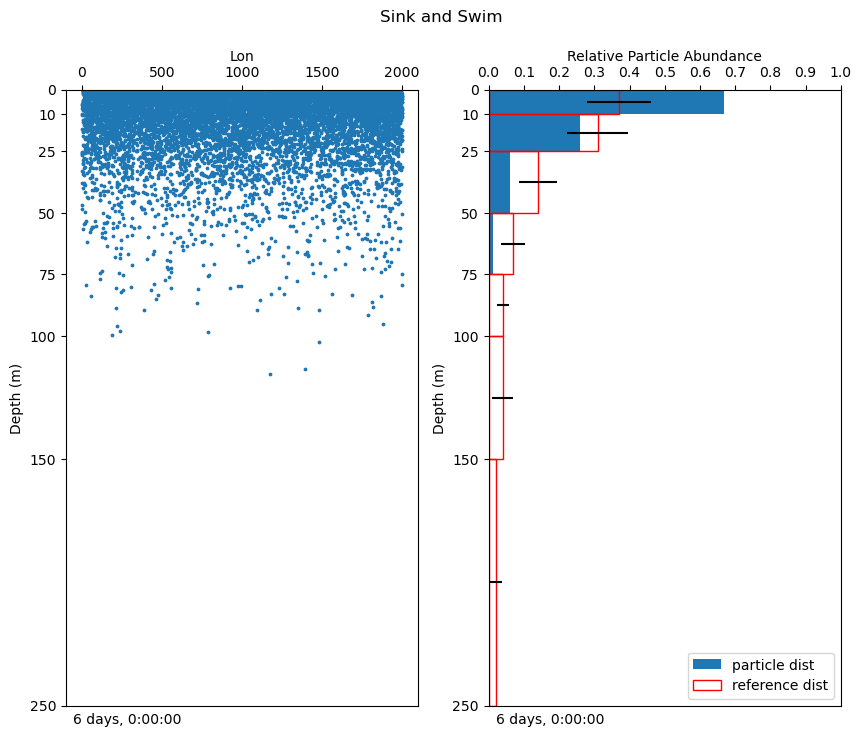

In [73]:
# sink_and_swim - final timestep
counts, bins = np.histogram(dat.z[:, -1], bins=[0, 10, 25, 50, 75, 100, 150, 250]) # Calculate the counts and bins for the histogram
bin_centers = [0,  10,  25,  50,  75, 100, 150] # Calculate the bin centers (for placing bins on the y-axis
binwidths = np.diff(bins) #[10, 15, 25, 25, 25, 50, 100] # Define the binwidths
relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
vertical_dist = [0.37, 0.31, 0.14, 0.07, 0.04, 0.04, 0.02] # bin means from all day and night LimS0 standard interval tows (n = 38)
xerr = [0.090, 0.087, 0.053, 0.034, 0.017, 0.030, 0.017] # 95% confidence intervals for the means from all day and night LimS0 standard interval tows (n = 38)
#tstamp = dat.time[0, -1].values.astype('timedelta64[ns]') / np.timedelta64(1, 'D')
tstamp = dat.time[0, -1].values.astype('timedelta64[D]').astype(datetime) # This is likely more computationally efficient than the above line, but doesn't give decimal places. Can change [D] to [M] for months

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.scatter(dat.lon[:,-1],dat.z[:,-1],s=3,c ='tab:blue')
ax1.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax1.set_ylim(0, 250)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Depth (m)')
ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes)
ax2.barh(bin_centers, relative_abundance, label = 'particle dist', height = binwidths, align = 'edge', color = 'tab:blue') # Create the histogram with bins on the y-axis and counts on the x-axis
ax2.barh(bin_centers, vertical_dist, label = 'reference dist', height = binwidths, align = 'edge', color = 'none', edgecolor ='r', xerr = xerr) # Plot reference vertical distribution
ax2.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax2.set_ylim(0, 250)
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
ax2.set_ylabel('Depth (m)')
ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes)
ax2.legend()
plt.suptitle('Sink and Swim')

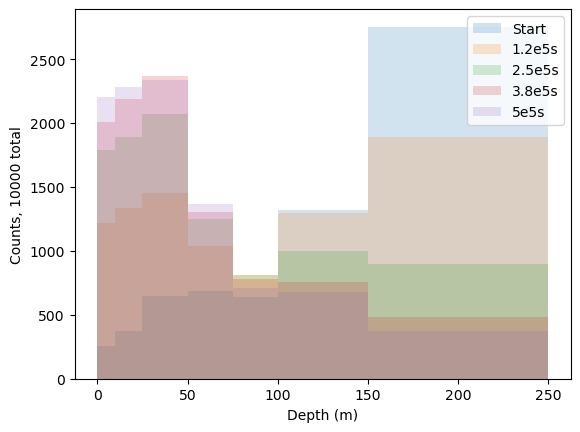

In [7]:
fig, ax = plt.subplots(1, 1)
ax.hist(dat.z[:, 0], bins = [0, 10, 25, 50, 75, 100, 150, 250], alpha=0.2, label='Start');
ax.hist(dat.z[:, 250], bins = [0, 10, 25, 50, 75, 100, 150, 250], alpha=0.2, label='1.2e5s');
ax.hist(dat.z[:, 500], bins = [0, 10, 25, 50, 75, 100, 150, 250], alpha=0.2, label='2.5e5s');
ax.hist(dat.z[:, 750], bins = [0, 10, 25, 50, 75, 100, 150, 250], alpha=0.2, label='3.8e5s');
ax.hist(dat.z[:, 1000], bins = [0, 10, 25, 50, 75, 100, 150, 250], alpha=0.2, label='5e5s');
ax.legend();
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Counts, 10000 total');

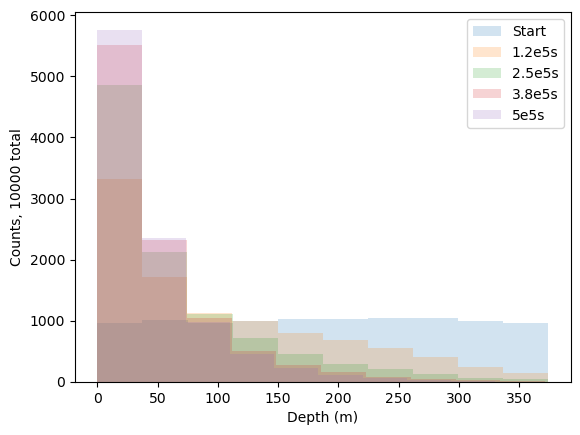

In [8]:
fig, ax = plt.subplots(1, 1)
ax.hist(dat.z[:, 0], alpha=0.2, label='Start');
ax.hist(dat.z[:, 250], alpha=0.2, label='1.2e5s');
ax.hist(dat.z[:, 500], alpha=0.2, label='2.5e5s');
ax.hist(dat.z[:, 750], alpha=0.2, label='3.8e5s');
ax.hist(dat.z[:, 1000], alpha=0.2, label='5e5s');
ax.legend();
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Counts, 10000 total');

View data

In [ ]:
print(dat)

Animations

In [ ]:
def anim(dat,fps=1):  
    fig, axs = plt.subplots(1,1,figsize=(5,10))
    axs.invert_yaxis()
    axs.set_title('Sink and Swim')
    axs.set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs.scatter(dat.lon[:,frame],dat.z[:,frame],s=3,c ='tab:blue'))                     
        print(f'{frame/len(dat):.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,1000,fps), interval=1)

In [ ]:
ss =[]
ani = anim(dat,fps=1)
f = r'/ocean/mattmiller/MOAD/results/parcels/test/_1.gif'
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

In [ ]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [ ]:
fig, axs=plt.subplots(1,1,figsize=(5,10))
axs.scatter(dat.lon[:,-1],dat.z[:,-1],s=3) # s = point size
#axs.plot(box[0],box[1],c='grey',linewidth=3)
axs.invert_yaxis()
axs.set_title('Sink and Swim')
axs.set_ylabel('Depth (m)')

In [ ]:

def anim(dat,fps=1):  
    fig, axs = plt.subplots(1,1,figsize=(5,10))
    binwidths = [10, 15, 25, 25, 25, 50, 100] # Define the binwidths
    bin_centers = [0,  10,  25,  50,  75, 100, 150]
    vertical_dist_medians = [0.350311667, 0.239004743, 0.113561039, 0.025229733, 0.007112793, 0.002542321, 0.003152159]
    axs.set_ylim(0, 250)
    axs.invert_yaxis() # flip y-axis
    axs.set_yticks([0, 10, 25, 50, 75, 100, 150, 250]) # Set the tick positions and labels for the y-axis
    axs.set_xticks(np.arange(0, 1.1, 0.1))
    axs.xaxis.set_ticks_position('top') # Move the x-axis to the top
    axs.xaxis.set_label_position('top')
    axs.set_xlabel('Relative Particle Abundance') # Add labels and title
    axs.set_ylabel('Depth (m)')
    plt.suptitle('Sink and Swim')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]        
        tstamp = dat.time[0, frame].values.astype('timedelta64[D]').astype(datetime)
        counts, bins = np.histogram(dat.z[:, frame], bins=[0, 10, 25, 50, 75, 100, 150, 250]) # Calculate the counts and bins for the histogram            
        relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
        ss.append(axs.barh(bin_centers, relative_abundance, label = 'particle dist', height=np.diff(bins), align='edge', color = 'tab:blue'))                             
        ss.append(axs.barh(bin_centers, vertical_dist_medians, label = 'reference dist', height=np.diff(bins), align='edge', color = 'none', edgecolor = 'r'))
        ss.append(axs.text(x = 0.02, y = -0.03, s = tstamp, transform=axs.transAxes))
        ss.append(axs.legend())
        print(f'{frame/len(dat.z.obs)*100:.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(dat.z.obs)-1,fps), interval=1)

In [ ]:
ss =[]
ani = anim(dat,fps=1)
f = r'/ocean/mattmiller/MOAD/results/parcels/test/60_days.gif'
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

In [ ]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [ ]:
def anim(dat,fps=1):  
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
    ax1.set_ylim(0,250)
    ax1.set_yticks([0, 10, 25, 50, 75, 100, 150, 250])
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlabel('Lon')
    ax1.set_ylabel('Depth (m)')
    ax2.set_ylim(0,250)
    ax2.invert_yaxis()
    ax2.set_yticks([0, 10, 25, 50, 75, 100, 150, 250]) # Set the tick positions and labels for the y-axis
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
    ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
    ax2.set_ylabel('Depth (m)')
    plt.suptitle('Sink and Swim')

    bin_centers = [0,  10,  25,  50,  75, 100, 150] # Calculate the bin centers (for placing bins on the y-axis)
    binwidths = np.diff([0, 10, 25, 50, 75, 100, 150, 250]) # Define the binwidths
    vertical_dist_medians = [0.350311667, 0.239004743, 0.113561039, 0.025229733, 0.007112793, 0.002542321, 0.003152159]

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]        
        ss.append(ax1.scatter(dat.lon[:,frame],dat.z[:,frame],s=3,c ='tab:blue')) 
        tstamp = dat.time[0, frame].values.astype('timedelta64[ns]').astype(datetime)
        ss.append(ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes))
        counts, bins = np.histogram(dat.z[:,frame], bins=[0, 10, 25, 50, 75, 100, 150, 250]) # Calculate the counts and bins for the histogram            
        relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
        ss.append(ax2.barh(bin_centers, relative_abundance, label = 'particle dist', height=binwidths, align='edge', color='tab:blue'))                             
        ss.append(ax2.barh(bin_centers, vertical_dist_medians, label = 'reference dist', height=binwidths, align='edge', color='none', edgecolor ='r'))
        ss.append(ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes))
        ss.append(ax2.legend())
        print(f'{frame/len(dat.z.obs)*100:.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(dat.z.obs)-1,fps), interval=1)

In [ ]:
ss =[]
ani = anim(dat,fps=1)
f = r'/ocean/mattmiller/MOAD/results/parcels/test/sink_and_swim.gif'
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

In [ ]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [ ]:
len(dat.z.obs)-1